In [6]:
from scipy.stats import (
    norm, binom, expon, t, chi2, pareto, ttest_ind, ttest_1samp,
    sem, beta, kstwobign, randint, kstest, shapiro, jarque_bera,
)
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.proportion import proportion_confint
from tqdm.notebook import tqdm
import numpy as numpy
from seaborn import distplot
from matplotlib import pyplot
import seaborn

import sys
sys.path.append('.')

import warnings
warnings.filterwarnings("ignore")

In [7]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [8]:
inverse_plot_colorscheme()

# Лекция 8. Критерии согласия

## Критерий согласия 

*или (goodness of fit)*

> 📈 **Задача**
>
> Вы купили новый красивый игральный кубик и хотите проверить, правда ли, что все грани у него выпадают равновероятно? 



Пусть мы накидали кубик n раз, и у нас появилась выборка $X_1, X_2 \dots X_n$. Как понять, честный ли кубик? Для этого нам помогут критерии согласия!

Какую задачу они решают? Есть выборка $X_1, X_2 \dots X_n$ из истинного распределения $\mathcal{P}$. Мы хотим проверить, а совпадает ли $\mathcal{P}$ с распределением $\mathcal{P_0}$?
   - Например, пусть распределение выпадений граней кубика $p_1, p_2, p_3, p_4, p_5, p_6$ (Это $\mathcal{P}$). Нас интересует, а не равновероятны ли все грани, то есть $p_i = \dfrac{1}{6}$ для любого i (Это $\mathcal{P_0}$). А наша выборка $X_i$ &mdash; результат i-ого броска кубика. 
       - С точки зрения теории вероятности число выпадений каждой грани кубика при N бросках описывается [мультиномиальным распределением](https://ru.wikipedia.org/wiki/Мультиномиальное_распределение).

То есть критерий согласия проверяет
- $H_0: \mathcal{P} = \mathcal{P}_0\ vs.\ H_1: \mathcal{P} \neq \mathcal{P}_0$.

Но иногда нас интересует равенство не одному распределению $\mathcal{P}_0$, а семейству распределений. Например, нас интересует, правда ли, что выборка $X_1, X_2 \dots X_n$ из нормального распределения? Гипотеза выше проверила бы, что выборка $X$ из нормального распределения с фиксированными параметрами $\mu, \sigma^2$.

Поэтому на самом деле есть **2 гипотезы у критерия согласия**:
- *Простая*: $H_0: \mathcal{P} = \mathcal{P}_0\ vs.\ H_1: \mathcal{P} \neq \mathcal{P}_0$
- *Сложная*: $H_0: \mathcal{P} \in \{\mathcal{P}_{\theta}| \theta \in \Theta \}$. То есть параметры не фиксированы.
    - Для нормального распределения $ \{\mathcal{P}_{\theta}| \theta \in \Theta \}$:
        - $\mathcal{P}$  &mdash; нормальное распределение, 
        - $\theta$ это пара $(\mu, \sigma^2)$
        - $\Theta = (-\infty, \infty) \times (0, \infty)$ (декартово произведение двух множеств)

#### Критерий Колмогорова для простой гипотезы

Сфокусируемся на простой гипотезе: $H_0: \mathcal{P} = \mathcal{P}_0\ vs.\ H_1: \mathcal{P} \neq \mathcal{P}_0$. Но заметим, что эту запись можно изменить: вместо того, чтобы сравнивать сами распределения мы можем сравнивать функции распределения между собой. Так как [распределение однозначно задается своей функцией распределения](https://stats.stackexchange.com/questions/136658/why-does-a-cumulative-distribution-function-cdf-uniquely-define-a-distribution).

Поэтому в дальнейшем мы будем писать, что критерий согласия проверяет $H_0: F = F_0\ vs.\ H_1: F \neq F_0$, *где $F, F_0$ &mdash; функции распределения*.

Ну а теперь закономерный вопрос: как проверять такую гипотезу? **Для этого нам надо придумать статистику и как она распределена при $H_0$**.



**Шаг 1. Оцениваем CDF, или $F(x)$**

Начнем издалека. Попробуем решить такую задачу: как аппроксимировать `cdf` выборки? Мы ее не знаем, но хотим как-то точно оценить. Что такое cdf по определению? Это вероятность получить такое или более маленькое значение случайной величины, $F(x) = P(X \leq x)$. Тогда рассмотрим статистику по выборке:

$$\widehat{F_n}(x) = \frac{1}{n}\sum_i[X_i \leqslant x]$$

Она по смыслу должна оценивать $F(x)$. Назовем **$\widehat{F_n}(x)$ &mdash; эмпирической функцией распределения**.

Что можно про эту оценку сказать: **на бесконечности $\widehat{F_n}(x) \stackrel{p}{\rightarrow} F(x)$**. ([сходимость по вероятности](https://tvims.nsu.ru/chernova/tv/lec/node53.html))

---

*Док-во*

- $F(x) = P(X \leq x) = 1 *  P(X \leq x) + 0 * P(X > x) = \mathbb{E} I\{X \leq x\}$, где $I$ &mdash; функция индикатор. Она равна 1, если выполнено условие в скобках.
- $\widehat{F_n}(x) = \frac{1}{n}\sum_i[X_i \leqslant x] = \overline{I\{X \leq x\}}$

Тогда по усиленному закону больших чисел (УЗБЧ):

$\widehat{F_n}(x) = \overline{I\{X \leq x\}} \stackrel{p}{\rightarrow} \mathbb{E} I\{X \leq x\} = F(x)$. ч.т.д.

---

Давайте это визуализируем.

- Возьмем некое распределение (например, экспоненциальное) и любую точку, например, 3.
- Посчитаем в ней истинную $F(x)$.
- Далее для разных n посчитаем $\widehat{F_n}(x)$.
- Построим график расстояния $\widehat{F_n}(x) - F(x)$. Чем больше n, тем меньше должно быть расстояние.

In [4]:
def calc_Fn(sample, x):
    """
        Функция строит эмпирическую функцию распределения по sample для Fn(x).
    """
    
    return numpy.mean(sample <= x)

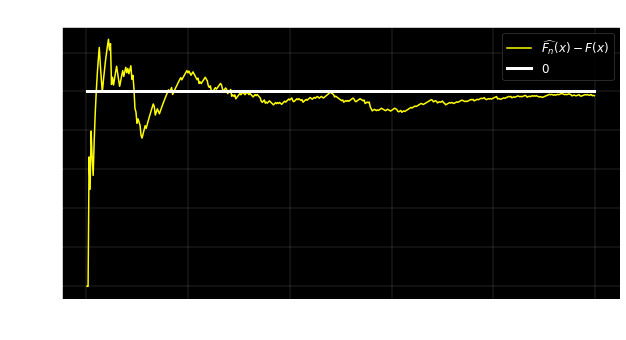

In [5]:
numpy.random.seed(42)
N = 5000
n_array = numpy.arange(10, N, 10)
# В качестве примера взяли экспоненциальное распределение
X = expon().rvs(N)
x = 3
F_x = expon().cdf(x)

delta = []
for n in n_array:
    # Считаем F_n_x по первым n сгенерированным точкам
    F_n_x = calc_Fn(X[:n], x)
    delta.append(F_n_x - F_x)


pyplot.figure(figsize=(10, 5))
pyplot.title('Распределение $\widehat{F_n}(x) - F(x)$, x фиксирован', fontsize=12)
pyplot.plot(n_array, delta, c='yellow', label='$\widehat{F_n}(x) - F({x})$')
pyplot.plot(n_array, [0] * len(n_array), c='white', linewidth=3, label='0')
pyplot.legend(fontsize=12)
pyplot.xlabel('Размер выборки', fontsize=12)
pyplot.ylabel('$\delta$', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Видим, что все так и есть!

Но что происходит в совокупности для всех x? Как $F_n(x)$ приближает $F(x)$ в каждой точке x?

> **Теорема Гливенко-Кантелли**
>
> Пусть $X_1, X_2 \dots $ &mdash; выборка неограниченного размера из распределения с функцией распределения $F$. Тогда
$$
    D_n = \underset{x \in \mathbb{R}}{\sup} |\widehat{F_n}(x) - F(x)| \stackrel{p}{\rightarrow} 0
$$

То есть наибольшая разница между нашей оценкой и истинной функцией распределения равна 0! Это еще более сильное утверждение чем то, что было выше: оно сразу говорит про $|\widehat{F_n}(x) - F(x)|$, на всей числовой прямой, а не про одну точку, как мы вывели ранее.


Время визуализации:
- Генерируем выборку.
- Считаем $F(x)$ в каждой точке x.
- Считаем $\widehat{F_n}(x)$ в каждой точке x.
- Строим графики в зависимости от n.

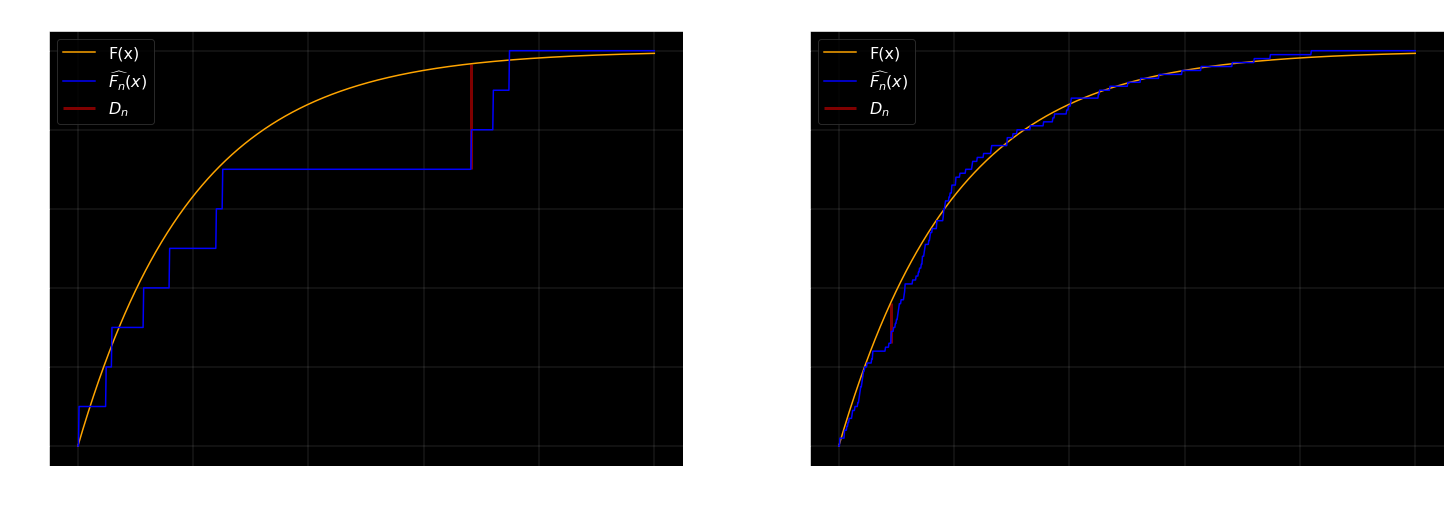

In [6]:
numpy.random.seed(4)
N = 1000
n_array = [10, 100]
X = expon().rvs(N)
# В этот раз не одна точка, а числовая прямая
x = numpy.linspace(0, 5, 1000)
F_x = expon().cdf(x)


pyplot.figure(figsize=(25, 8))


for ind, n in enumerate(n_array):
    F_n_x = numpy.array([calc_Fn(X[:n], x_dot) for x_dot in x])
    
    # Рисуем Dn на графике
    # Считаем delta 
    delta = numpy.abs(F_n_x - F_x)
    # Ищем индекс максимального значения
    x_ind = numpy.argmax(delta)
    # По индексу получаем точку x, при которой наибольшее расстояние
    dn_x_dot = x[x_ind]
    # Ищем нижнюю и верхнюю точки
    down_bound = min(F_n_x[x_ind], F_x[x_ind])
    up_bound = max(F_n_x[x_ind], F_x[x_ind])
    
    pyplot.subplot(1, 2, ind + 1)
    pyplot.title('$\widehat{F_n} - F$, ' + f'n={n}', fontsize=16)
    pyplot.plot(x, F_x, color="orange", label='F(x)')
    pyplot.plot(x, F_n_x,color="blue", label='$\widehat{F_n}(x)$')
    pyplot.vlines(dn_x_dot, down_bound, up_bound,
               color='maroon', linestyle='-', linewidth=3, label='$D_n$')
    pyplot.legend(fontsize=16)
    pyplot.grid(linewidth=0.2)
    pyplot.xlabel('x', fontsize=16)
    pyplot.ylabel('Вероятность', fontsize=16)

pyplot.show()

Чем больше n, тем более точно мы предсказываем $F(x)$ на вcей числовой прямой.

**Итого** на шаге 1 мы получили оценку $F(x)$ по выборке, которая с ростом n становится все более точной. Но пока это не приблизило нас к критерию.

-----

**Шаг 2. Придумываем статистику критерия Колмогорова**

Мы научились приближать $F(x)$. Теперь давайте подумаем, что значит, что $F = F_0$? Если это так, то 
    $$\begin{align}
        &\forall x \in \mathbb{R}\ F(x) = F_0(x) \Leftrightarrow \\
        &\forall x \in \mathbb{R}\ |F(x) - F_0(x)| = 0 \Leftrightarrow \\
        &\underset{x \in \mathbb{R}}{\sup} |F(x) - F_0(x)| = 0
    \end{align}
    $$
  
Хм, что-то похожее на то, что мы считали в прошлом шаге... Давайте заменим $F(x)$ на оценку: эмпирическую функцию распределения. Тогда **статиcтика критерия будет** 
$$
    D_n = \underset{x \in \mathbb{R}}{\sup} |\widehat{F_n}(x) - F_0(x)|
$$
Именно ее предложил Колмогоров в свое время.

Что мы знаем уже про эту оценку?
- При $H_0: D_n \stackrel{p}{\rightarrow} 0$

Но этого мало: с помощью этой информации критерий не построить. Нам не хватает распределения.

-----

**Шаг 3. Распределение статистики критерия Колмогорова**


> Теорема Колмогорова
>
> Пусть выборка $X$ из непрерывного распределения. Тогда при $H_0$ $\sqrt{n}D_n \stackrel{d}{\rightarrow} \phi$, где $\phi$ имеет распределение Колмогорова: $F_\phi(x) = \begin{equation*} 
 \begin{cases}
  \sum\limits_{k=-\infty}^ \infty (-1)^k e^{-2k^2 x^2}, &\text{ $ x > 0$}\\
   0, &\text{ $ x < 0$}
 \end{cases}
\end{equation*}$

То есть, с ростом n $D_n \rightarrow 0$, а $\sqrt{n}D_n \rightarrow \phi$.

Давайте графически посмотрим, как распределена статистика Колмогорова, и как она ведет себя при малых n. Для этого мы:

1. Сгенерируем 1000 экспериментов и в каждом из них посчитаем статистику $\sqrt{n}D_n$.
2. В каждом эксперименте сгенерируем выборку.
3. Посчитаем статистику D. Вопрос состоит в том, в каких точках считать статистику? Точек $x$ бесконечно много, неужели проверять все?
    - **На самом деле достаточно проверить лишь точки изменения $\widehat{F_n}(x)$. А ее значения меняются лишь в точках реализации выборки $X$.**
        - Почему именно в них? Из-за монотонности функций. Рассмотрим интервал $[X_{(i)}, X_{(i + 1)})$ &mdash; 2 подряд стоящие точки в выборке.
            - $F(X_{(i)}) \leq F(X_{(i + 1)})$
            - $\widehat{F_n} = C$ &mdash; константа на этом интервале.
            - Тогда максимум либо в точке $X_{(i)}$, либо в $X_{(i + 1)} - \text{eps}$. 
                - Но если распределение абсолютно непрерывно, то мы можем смотреть вместо $X_{(i + 1)} - \text{eps}$ точку $X_{(i + 1)}$. Так как $F(X_{(i + 1)}) \approx F(X_{(i + 1)} - \text{eps})$.
                - Максимальная дельта на интервале будет или $|F(X_{(i)}) - C|$ или $|F(X_{(i + 1)}) - C|$. Промежуточные точки смотреть бесполезно, как раз-таки из-за монотонности $F(X)$.
                - Но в точке $X_{(i + 1)}$ надо брать значение $\widehat{F_n}(X_{(i)})$, а не $\widehat{F_n}(X_{(i + 1)})$. Потому что это распределение дискретно и $\widehat{F_n}(X_{(i + 1)}) \neq \widehat{F_n}(X_{(i + 1)} - \text{eps})$
                    - ограничение - Дискрентные распределения. Там не надо проверять смещения. 
4. Построим гистограмму.
5. Построим распределение Колмогорова. В Python за него отвечает [kstwobign](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstwobign.html#scipy.stats.kstwobign).
6. Повторим аналогичное упражнение для разных размеров выборок

In [7]:
def get_D_statistic(sample, cdf_func):
    """
        Считаем статистику D для выборки. Не работает для дискретных распределений.
        Параметры:
            - sample: выборка
            - cdf_func: функция построения cdf для F0
            
    """
    
    # Сортируем выборку, чтобы получить интервалы X_i, X_i+1
    sample = numpy.sort(sample)
    # Считаем эмпирическую функцию распределения
    F_n_x = numpy.array([calc_Fn(sample, x) for x in sample])
    # Сдвигаем на 1 вправо, чтобы посчитать разницу в точке X_i+1
    F_n_x_shifted = numpy.concatenate([[0], F_n_x[:-1]])
    # Строим массив значений F(X)
    F_x = cdf_func(sample)
    
    F_x_shifted = cdf_func(sample)
    # Определяем максимальное расстояние в левых точках интервала X_i
    left_interval_max = numpy.max(numpy.abs(F_x - F_n_x))
    # Определяем максимальное расстояние в правых точках интервала X_i+1
    right_interval_max = numpy.max(numpy.abs(F_x_shifted - F_n_x_shifted))
    return max(left_interval_max, right_interval_max)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

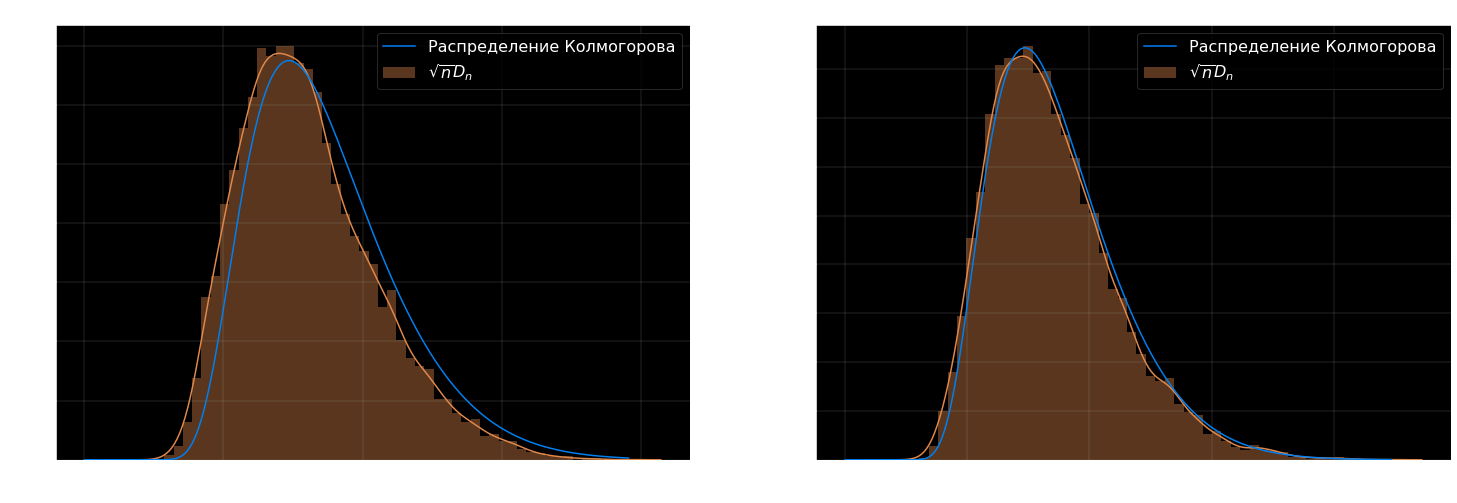

In [8]:
numpy.random.seed(8)
n_array = [5, 100]
distribution = expon()
exp_size = 10000


pyplot.figure(figsize=(25, 8))

# Для разных размеров выборок построим графики
for ind, n in tqdm(enumerate(n_array), total=len(n_array)):
    
    statistics = []
    # Генерируем exp_size экспериментов
    for i in tqdm(range(exp_size), leave=False):
        X = distribution.rvs(n)
        statistics.append(get_D_statistic(X, distribution.cdf) * numpy.sqrt(n))
    

    pyplot.subplot(1, 2, ind + 1)
    pyplot.title(f'Визуализация распределения статистики Колмогорова, N={n}', fontsize=16)
    distplot(statistics, label='$\sqrt{n}D_n$')
    x_array = numpy.linspace(0, numpy.max(statistics), 1000)
    pyplot.plot(x_array, kstwobign.pdf(x_array), label='Распределение Колмогорова')
    pyplot.legend(fontsize=16)
    pyplot.grid(linewidth=0.2)
    pyplot.xlabel('Значение статистики', fontsize=16)
    pyplot.ylabel('Плотность', fontsize=16)
pyplot.show()

Мы видим, что даже несмотря на то, что метод асимптотический, распределение Колмогорова достаточно хорошо приближает $\sqrt{n}D_n$ даже при малых размерах выборок. Но есть небольшой сдвиг в большую сторону, что хорошо, так как критерий будет ошибаться меньше, чем в $\alpha$% случаев. Но для малых размеров выборок были теоретически изобретены поправки, чтобы распределение описывало и эти случаи.



Какой будет критическая область у этого критерия? Мы будем отвергать гипотезу только в случае, если $D_n$ очень большое. А значит нас интересует лишь правая область распределения Колмогорова.

### Критерий Колмогорова

$H_0: F=F_0\ vs.\ H_1: F \neq F_0$. **Важно помнить, что критерий работает для непрерывных распределений!**
- Статистика $D_n = \underset{x \in \mathbb{R}}{\sup} |\widehat{F_n}(x) - F_0(x)|$
- При достаточно большом размере выборки $\sqrt{n} D_n \sim \phi$, где $\phi$ имеет распределение Колмогорова (по теореме Колмогорова-Смирнова)
- критерий: $\left\{\sqrt{n} D_n \geq u_{1 - \alpha} \right\}$, где $u_{1 - \alpha}$ &mdash; $1 - \alpha$ квантиль распределения Колмогорова
    - `p-value = 1 - kstwobign.cdf(d)`, где d &mdash; реализация статистики $\sqrt{n}D(X)$, `kstwobign` &mdash; функция распределения Колмогорова.

**Критерий Колмогорова есть в библиотеке stats**

- `scipy.stats.kstest` &mdash; [библиотека](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) для критерия Колмогорова, Колмогорова-Смирнова.

В качестве cdf можно строкой указать распределение из scipy.stats. В таком случае аргументы распределения подаются на вход отдельно через args: 

In [9]:
sample = norm(0.10, 0.04).rvs(10)


Dn, p = kstest(rvs=sample, cdf='norm', args=(0.10, 0.04))
print(f'p-value: {p:.4f}')

p-value: 0.6972


Можно указать cdf в виде lambda-функции от $x$:

In [10]:
Dn, p = kstest(rvs=sample, cdf=lambda x: norm.cdf(x, loc=0.10, scale=0.04))
print(f'p-value: {p:.4f}')

p-value: 0.6972


In [11]:
# для модников
from typing import Callable

def norm_cdf_closure(loc: float, scale: float) -> Callable:
    """Можно самостоятельно написать функцию"""
    def inner_norm_cdf(x):
        return norm.cdf(x=x, loc=loc, scale=scale)
    return inner_norm_cdf

# вместо 'norm' можно в явном виде указать любую функцию распределения
Dn, p = kstest(sample, norm_cdf_closure(loc=0.10, scale=0.04))
print(f'p-value: {p:.4f}')

p-value: 0.6972


Можно заметить, что вне зависимости от варианта программы, результат совпадает 😊 

### Проверка критерия

Теперь давайте проверим с помощью Монте-Карло, как работает критерий на практике, а не с помощью визуализаций:

In [12]:
def check_kstest(dist, sample_size, N_exps=10000, to_print=True):
    """
        Функция для проверки критерия Колмогорова
        Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.
    
        Параметры:
            - dist: Распределение выборки
            - sample_size: размер выборки
            - N_exps: число экспериментов, по которым потом считается FPR
            - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """
    
    numpy.random.seed(35)
    bad_cnt=0
    alpha=0.05

    for i in tqdm(range(N_exps)):
        # Генерирую выборку
        sample = dist.rvs(sample_size)

        # Запускаю критерий и считаю p-value
        pvalue = kstest(sample, cdf=dist.cdf).pvalue

        # Проверяю, что pvalue < alpha
        bad_cnt += (pvalue < alpha)

    if to_print:
        print(f"FPR: {round(bad_cnt / N_exps, 4)}")
        print(f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
    else:
        return proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')

Проверим критерий для экспоненциального распределения:

In [13]:
check_kstest(expon(scale=10), sample_size=5, N_exps=10000, to_print=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.0478
CI=(0.043789399861243195, 0.05215788826519671)


А что будет, если мы воспользуемся критерием Колмогорова для дискретных распределений?

In [14]:
check_kstest(randint(1, 7), sample_size=100, N_exps=10000, to_print=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 1.0
CI=(0.9996160016293234, 1.0)


Он всегда отвергает гипотезу. Хотя она верна. **Поэтому не стоит использовать этот критерий для дискретных распределений!**

**Итого, мы НЕ умеем решать задачу для дискретных распределений, но умеем для непрерывных!**

---

## Проверка сложных гипотез про нормальное распределение


Все предыдущие рассуждения мы вели для проверки простой гипотезы. Давайте разберемся, как проверять сложную гипотезу, но пока только для нормального распределения.


> 📈 **Задача**
>
> Мы нашли в интернете доказательство, что отношение 2 независимых случайных величин из разных нормальных распределений &mdash; это нормальное распределение, в случае, если знаменатель "маловероятно будет близ 0" ([ссылка](https://link.springer.com/article/10.1007/s00362-012-0429-2)). Как это проверить на практике? 

**Идея**
- Насимулируем выборку отношений большого размера.
- На этой выборке проверим гипотезу $H_0:$ выборка из нормального распределения.
- Так мы проверим работоспособность критерия на каком-то случайном примере.


### Критерий Колмогорова для проверки сложных гипотез про нормальное распределение


Но как проверить сложную гипотезу? Первая идея: давайте оценим параметры $\mu, \sigma^2$ по выборке. Похожее мы делали в t-test и там это сработало.
- $\widehat{\mu} = \overline X$
- $\widehat{\sigma^2} =S^2 = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$

In [9]:
def estimated_params_kstest(sample):
    """Придуманный критерий"""
    
    mu = numpy.mean(sample)
    sigma = numpy.std(sample, ddof=1)
    dist = norm(loc=mu, scale=sigma)
    return kstest(sample, cdf=dist.cdf).pvalue

Проверим на практике критерий:

In [10]:
N = 1000
num = norm(loc=100, scale=10).rvs(N)
den = norm(loc= -1000, scale=25).rvs(N)

sample = num / den
estimated_params_kstest(sample)

0.7997544280263768

На первый взгляд, все выглядит неплохо, но это впечатление обманчиво. Ведь по-настоящему критерии проверяются через Монте-Карло! И сначала на простом примере, где точно верна $H_0$.

In [11]:
def check_criterion(criterion, sample_size, N_exps=10000, to_print=True):
    """
        Функция для проверки придуманного критерия
        Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.
    """
    
    numpy.random.seed(42)
    bad_cnt=0
    alpha=0.05

    for i in tqdm(range(N_exps)):
        # Генерирую выборку
        sample = norm(loc=100, scale=10).rvs(sample_size)

        # Запускаю критерий и считаю p-value
        pvalue = criterion(sample)

        # Проверяю, что pvalue < alpha
        bad_cnt += (pvalue < alpha)

    if to_print:
        print(f"FPR: {round(bad_cnt / N_exps, 4)}")
        print(f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')}")
    else:
        return proportion_confint(count = bad_cnt, nobs = N_exps, alpha=0.05, method='wilson')

In [18]:
check_criterion(estimated_params_kstest, sample_size=1000, N_exps=10000, to_print=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.0
CI=(0.0, 0.0003839983706765959)


Коэффициент ложных срабатываний (FPR) равен нулю. Что это значит на практике? **Что где-то есть ошибка!**
- В общем случае, если вы придумали критерий, и он дает FPR равный 0, значит это плохой критерий! Почему? Потому что он будет менее мощным чем другой критерий с уровнем значимости 5%!
    - Значит, придуманный критерий плох!

Мы оценили параметры по нашей выборке, а потом подставили их в распределение. В этом случае произошло "переобучение под данные". Наши параметры всегда были подобраны идеально для полученной выборки, хотя на самом деле они другие!


In [12]:
sample = norm(loc=100, scale=10).rvs(1000)
mu = numpy.mean(sample)
sigma = numpy.std(sample, ddof=1)
mu, sigma

(100.24918964915919, 9.951902255273907)

Мы видим, что они отличаются от истинного значения. Эти отличия и делают FPR около 0.

Для того, чтобы решить эту проблему ученые  насемплировали статистику $D_n$ и с помощью метода Монте-Карло построили критические области для разных $\alpha$ для этой статистики.
И назвали новый критерий **критерием  Колмогорова с поправкой Лиллиефорса**.


#### Критерий Колмогорова с поправкой Лиллиефорса в библиотеке statsmodels
 [statsmodels.stats.diagnostic.lilliefors](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.lilliefors.html) — Критерий Лиллиефорса. 

In [13]:
Dn, p = lilliefors(sample, dist='norm', pvalmethod='table') 
print(f"Kolmogorov-Lilliefors' Dn statistic: {Dn:.4f},\np-value: {p:.4f}")

Kolmogorov-Lilliefors' Dn statistic: 0.0148,
p-value: 0.9103


Проверим критерий через Монте-Карло:

In [14]:
lilliefors_crierion = lambda sample: lilliefors(sample, dist='norm')[1]
check_criterion(lilliefors_crierion, sample_size=1000, N_exps=10000, to_print=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.0384
CI=(0.0348075417687003, 0.04234696552710831)


FPR все также занижен, но он сильно больше, чем у придуманного нами ранее критерия. Поэтому он мощнее, а значит и лучше!

Проверим теперь: правда ли, что отношение нормальных величин распределено нормально?

In [15]:
N = 1000
num = norm(loc=100, scale=10).rvs(N)
den = norm(loc= -1000, scale=25).rvs(N)

sample = num / den
Dn, p = lilliefors(sample, dist='norm', pvalmethod='table') 
print(f"Kolmogorov-Lilliefors' Dn statistic: {Dn:.4f},\np-value: {p:.4f}")

Kolmogorov-Lilliefors' Dn statistic: 0.0157,
p-value: 0.8520


Да, так оно и есть! А если бы знаменатель был близок к 0?

In [16]:
N = 1000
num = norm(loc=100, scale=10).rvs(N)
den = norm(loc= -10, scale=25).rvs(N)

sample = num / den
Dn, p = lilliefors(sample, dist='norm', pvalmethod='table') 
print(f"Kolmogorov-Lilliefors' Dn statistic: {Dn:.4f},\np-value: {p:.4f}")

Kolmogorov-Lilliefors' Dn statistic: 0.3789,
p-value: 0.0010


В этом случае выборка не из номального распределения!

Итого, мы рассмотрели первый метод, а именно Критерий Колмогорова с поправкой Лиллиефорса.

----

### Критерий Шапиро-Уилка

Также является критерием согласия для нормального распределения. И также, как критерий Лиллиефорса, он проверяет сложную гипотезу (когда параметры не оценены).
У него логика такая же, как и в предыдущем случае: ученые придумали некую статистику и с помощью метода Монте-Карло оценили критические области для статистики при разных $\alpha$.


- `scipy.stats.shapiro` &mdash; [реализация в Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Проверим критерий:

In [24]:
shapiro_criterion = lambda sample: shapiro(sample).pvalue
check_criterion(shapiro_criterion, sample_size=1000, N_exps=10000, to_print=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.0523
CI=(0.04810587403933279, 0.05683795810177102)


FPR у него более точный, чем у критерия Колмогорова.

Теперь же рассмотрим графический метод принадлежности нормальному распределению: Q–Q plot. Это будет не критерий, а именно визуализация.

---

### Q–Q plot


Предположим, что у нас есть два нормальных распределения $\mathcal{N}(\mu, \sigma^2)$ и $\mathcal{N}(\mu', \sigma'^2)$. 

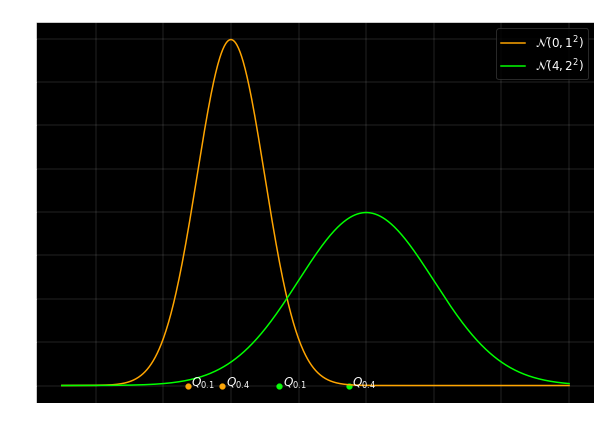

In [27]:
x = numpy.linspace(-5, 10, 1000)
dist_params = {
    "1": (0, 1),
    "2": (4, 2)
}
colors = {
    "1": 'orange',
    "2": 'lime'
}
quantiles = {
    "1": [0.1, 0.4],
    "2": [0.1, 0.4],
}

pyplot.figure(figsize=(10, 7))
pyplot.title('График двух нормальных распределений', fontsize=12)
for index in dist_params:
    params = dist_params[index]
    mu, sigma = params
    color = colors[index]
    q_array = quantiles[index]
    distr = norm(mu, sigma)
    pyplot.plot(x, distr.pdf(x), label='$\mathcal{N}$' + f'$({mu}, {sigma}^2)$', color=color)
    for q in q_array:
        dot_x = distr.ppf(q)
        pyplot.scatter(dot_x, 0, linewidth=0.2, color=color)
        pyplot.text(dot_x + 0.1, 0, "$Q_{" + str(q) + "}$", fontsize=12) 

pyplot.legend(fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Пусть $\alpha, \beta$ &mdash; разные квантили. Обозначим через $Q_{\alpha}$ квантили рыжего графика, и $Q'_{\alpha}$ квантили зеленого графика.
Докажем, что $$\frac {Q_{\beta}-Q_{\alpha}}{Q'_{\beta}-Q'_{\alpha}} =\frac{\sigma}{\sigma'}, i=1, 2,..., 9 $$

> Напомним пару необходимых для дальнейшего доказательства свойств для нормального распределения:
> $\xi_1 \sim \mathcal{N}(\mu_1, \sigma_1^2),\ \xi_2 \sim \mathcal{N}(\mu_2, \sigma_2^2) \Rightarrow \xi_1 + \xi_2 \sim \mathcal{N}(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)$
>
> $a \xi_1 \sim \mathcal{N}(a\mu_1, a^2\sigma_1^2)$,
>
> $a + \xi_1 \sim \mathcal{N}(a + \mu_1, \sigma_1^2)$.

Используя свойства нормального распределения, указанные выше:

- $\mathcal{N}(\mu,\sigma^2).ppf(\alpha) \cdot b + a = \mathcal{N}(\mu \cdot b +a, b^2 \cdot \sigma^2).ppf(\alpha)$. Это также видно на графике


Пусть 
- $\sigma' =\sigma \cdot b,$ а $\mu' = \mu \cdot b + a$. 
- Тогда $b=\frac{\sigma'}{\sigma}$, и $a=\mu'- \mu \cdot \frac{\sigma'}{\sigma}$.
- Продолжим наше равенство: $\mathcal{N}(\mu \cdot b +a, b^2 \cdot \sigma^2).ppf(\alpha) = \mathcal{N}(\mu', \sigma'^2).ppf(\alpha)$ 


Из этого следует, что :
1. $Q_{\alpha}\cdot b +a = Q'_{\alpha}$
2. $Q_{\beta}\cdot b +a = Q'_{\beta}$

Вычтем из первого равенства второе и получим:

1. $Q_{\beta} \cdot b + a  - (Q_{\alpha}\cdot b + a) = Q'_{\beta} - Q'_{\alpha}$

2. $Q_{\beta}\cdot b  - Q_{\alpha}\cdot b  = Q'_{\beta} - Q'_{\alpha} $

3. $ b \cdot(Q_{\beta}  - Q_{\alpha})  = Q'_{\beta} - Q'_{\alpha}$

4. $\frac{Q'_{\beta} - Q'_{\alpha}}{Q_{\beta}  - Q_{\alpha}} = b $, а т.к.  $b=\frac{\sigma'}{\sigma}$

5. $\frac{Q'_{\beta} - Q'_{\alpha}}{Q_{\beta}  - Q_{\alpha}}  = \frac{\sigma'}{\sigma} $ ч.т.д

Итак, получается, что если разность соседних квантилей одного распределения поделить на разность таких же соседних квантилей другого распределения (одно получается из другого линейным преобразованием), то это всегда константа. Для чего же это может нам понадобиться? И тут мы переходим к Q-Q Plot.

### Постановка задачи QQ-plot

QQ-plot &mdash; метод, который позволяет визуализировать "насколько хорошо" данные описываются нормальным распределением. В отличие от критериев этот метод не говорит, что он отвергает или не отвергает нормальность данных, но позволяет визуально посмотреть, насколько данные нормальны! Уметь грамотно визуализировать данные &mdash; одна из основных задач аналитика, и QQ-плот это лучший метод для визуализации нормальности данных.


**Визуализация QQ-плот**
- Пусть распределение выборки &mdash; $\mathcal{N}(\mu, \sigma^2)$.
- Найдем квантили 2 распределений: $\mathcal{N}(\mu, \sigma^2)$ и $\mathcal{N}(0, 1)$. Их квантили будут соответственно $Q, Q'$.
- Отложим квантили первого распределения по оси Y, а второго - по оси X.
- Тогда выведенное выше правило утверждает, что все точки $(Q'_{\alpha}, Q_{\alpha})$ лежат на одной прямой.
    -  Тангенс угла наклона этой прямой всегда один и тот же и равен $\frac{\sigma'}{\sigma}$. 
    
    
Для визуализации угла наклона воспользуемся [функцией из matplotlib](https://matplotlib.org/stable/gallery/text_labels_and_annotations/angle_annotation.html).

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])


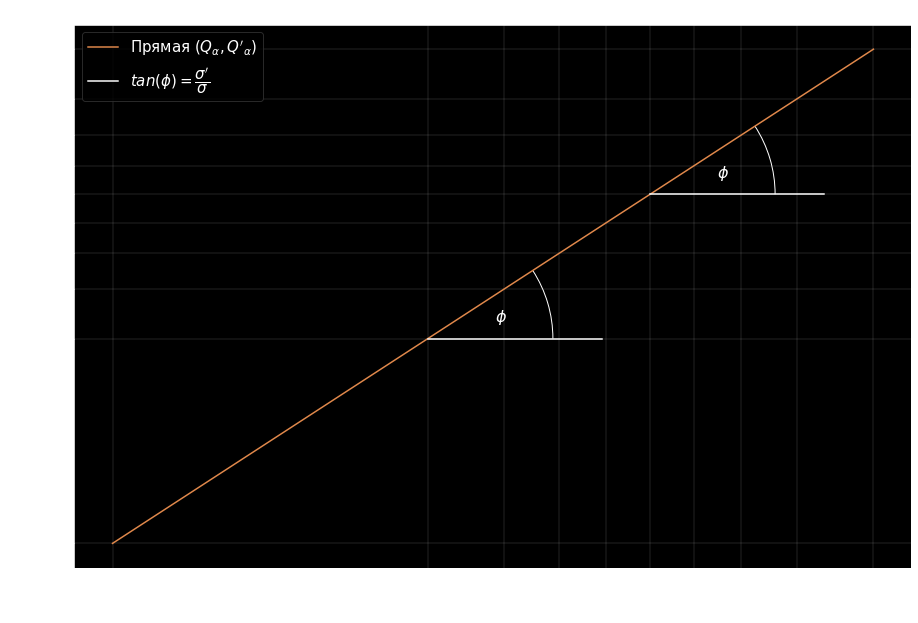

In [29]:
mu = 5
sigma = 10
sample_distr = norm(loc=mu, scale=sigma)
standart_distr = norm(loc=0, scale=1)
quantiles = np.arange(0.001, 1, 0.1)
quantle_xticks = ["$Q_{" + str(round(x, 2)) + "}$" for x in quantiles]
quantle_yticks = ["$Q'_{" + str(round(x, 2)) + "}$" for x in quantiles]
standart_q = standart_distr.ppf(quantiles)
sample_q = sample_distr.ppf(quantiles)


fig = pyplot.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
pyplot.title('QQ-Plot, визуализация на идеальных данных', fontsize=15)


ax.plot(standart_q, sample_q, label="Прямая $(Q_{\\alpha}, Q'_{\\alpha})$")
for index in [1, 5]:
    center = (standart_q[index], sample_q[index])
    dot1 = (standart_q[index] + 1, sample_q[index])
    dot2 = (standart_q[index + 1], sample_q[index + 1])
    
    label=""
    if index == 1:
        label="$tan(\phi) = \dfrac{\sigma'}{\sigma}$"
    am1 = AngleAnnotation(center, dot1, dot2, ax=ax, size=250, text=r"$\phi$", text_kw=dict(fontsize=16))
    ax.plot(*zip(*[center, dot1]), color='white', label=label)


pyplot.ylabel("Квантили $\mathcal{N}(\mu, \sigma^2)$", fontsize=15)
pyplot.xlabel("Квантили $\mathcal{N}(0, 1)$", fontsize=15)
pyplot.xticks(standart_q, quantle_xticks, fontsize=15)
pyplot.yticks(sample_q, quantle_yticks, fontsize=15)
pyplot.legend(fontsize=15)
pyplot.grid(linewidth=0.2)
pyplot.show()

Если отложить все отрезки с координатами $(Q_{0.i},Q'_{0.i});(Q_{0.i+0.1},Q'_{0.i+0.1})$, то можно заметить, что во всех случаях угол $\phi_i$ будет одинаковым.  Давайте посмотрим, чему же равен угол $\phi_i$.

$$\begin{align}
   \phi_i = arctg \left({\frac {Q'_{0.i+0.1}-Q'_{0.i}}{Q_{0.i+0.1}-Q_{0.i}}}\right) = arctg \left({\frac{\sigma'}{\sigma}}\right) = arctg(b) 
\end{align}
$$

Таким образом, можно сделать вывод: если построить график квантилей двух нормальных распределений, то это будет прямая. Это и будет Q-Q плот.

>Замечание! Необязательно только для нормальных распределений Q–Q plot будет прямой. Для всех распределений, которые переводятся друг в друга линейными преобразованиями, графиком Q–Q plot будет прямая.

----

Теперь давайте построим настоящий график QQ-plot для выборки. Для этого сделаем все то же самое, что и делали выше, только квантили получим по выборке.

- Пусть у нас N точек в выборке.
- Тогда оценка i-ой квантили &mdash; i значение в отсортированной выборке (вспоминаем эмпирическую функцию распределения из 1 части). $\widehat{F_n}(x) = \dfrac{1}{N}\sum([X_i \leq x])$.
- Построим квантили стандартного нормального распределения.
    - Для этого посчитаем квантиль в каждой точке $\dfrac{i}{N},\ i \in \{1, ...\ N - 1\}$
- Отложим оценки квантилей первого распределения по оси Y, а истинные квантили второго распределения - по оси X.
- Если график напоминает прямую, значит считаем, что это нормальное распределение.



In [30]:
def my_qq_plot(sample):
    """
        Функция для отрисовки QQ-Plot.
    """
    
    # Строим оценку квантилей
    # Сортируем выборку
    sample.sort()
    # Сами значения и есть оценки квантили
    sample_quantiles = sample[1:-1]
    N = len(sample)

    # Считаем N-2 точки квантилей стандартного нормального распределения (без +- бесконечности)
    x = [i / N for i in range(1, N - 1)]
    theoretical_quantiles = norm().ppf(x)
    
    # Визуализация
    fig = pyplot.figure(figsize=(15, 10))
    ax = fig.add_subplot(1,1,1)

    ax.plot(theoretical_quantiles, sample_quantiles, 'k.', linewidth=1.0, color = 'green')

    ax.set_xlabel('theoretical quantiles', fontsize=15)
    ax.set_ylabel('sample quantiles', fontsize=15)
    ax.set_title('QQ-Plot для выборки из нормального распределения', fontsize=15)
    pyplot.grid(linewidth=0.2)
    pyplot.show()

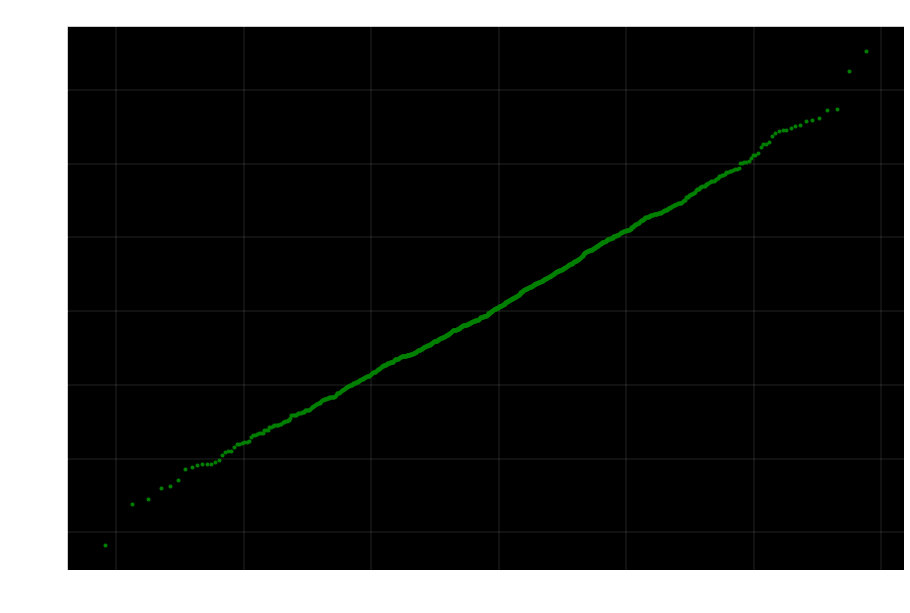

In [31]:
numpy.random.seed(102)
sample = norm(loc=100, scale=1000).rvs(size=1000)
my_qq_plot(sample)

Можно заметить, что наш график очень напоминает прямую. Конечно, в данном случае мы взяли не совсем квантили, а выборочные квантили, но тем не менее, линейность довольно четко прослеживается.

-----

Давайте рассмотрим следующий пример. 

Допустим, мы захотели построить график загрузки нашего сайта в секундах. Мы взяли в наших логах последние 20 значений (в секундах) от разных пользователей, и построим график Q–Q plot для этой выборки.

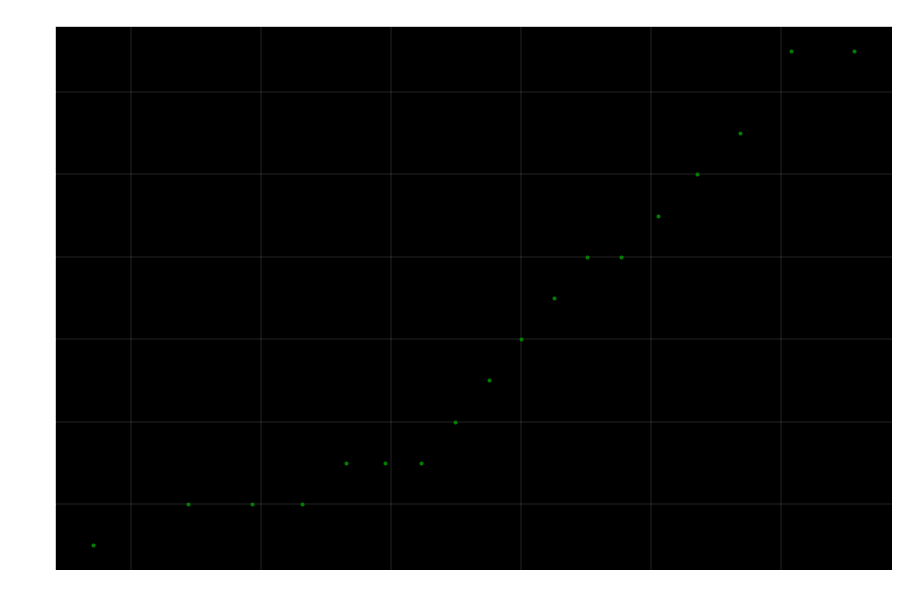

In [32]:
sample = [0.11, 0.07, 0.1, 0.09, 0.17, 0.14, 0.05, 0.05, 0.17, 0.07, 0.06, 0.06, 0.12, 0.12, 0.08, 0.15, 0.07, 0.06, 0.13, 0.17]
my_qq_plot(sample)

Заметим, что наш график уж совсем отдаленно напоминает прямую. Маловероятно, что наша выборка была получена из нормального распределения.

---

Давайте посмотрим, а как будет вести себя наш график, если мы проверим на соответствие нормальному распределению другие распределения? Возьмем выборку из распределения Стьюдента с тремя степенями свободы и сравним его с нормальным распределением.

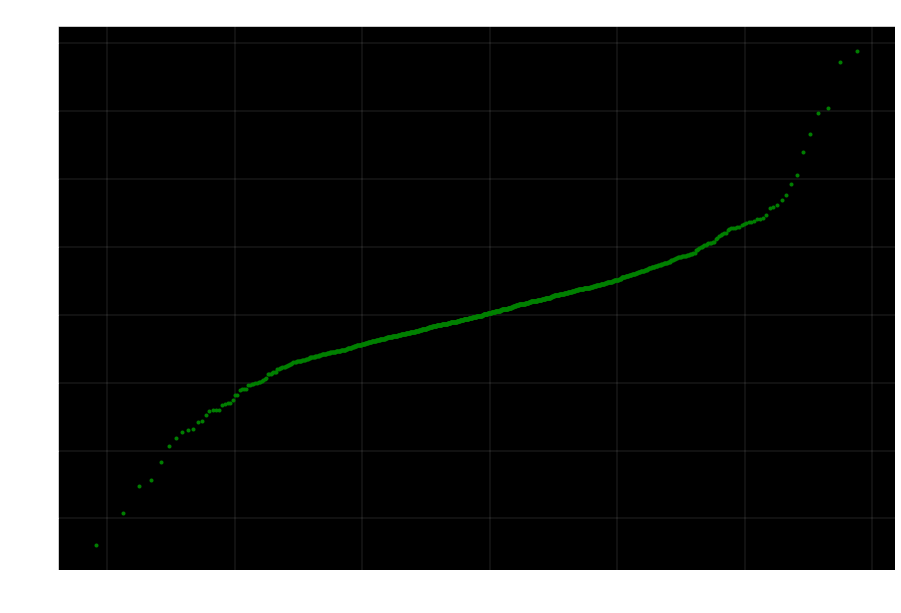

In [33]:
from scipy.stats import t
numpy.random.seed(102)
sample = t(df=3).rvs(size=1000)

my_qq_plot(sample)

Можно заметить, что в данном случае наш график не похож на линейную функцию. Можно сделать вывод: действительно, наша выборка была получена не из нормального распределения.

## Statsmodels

Перейдем к библиотечным вариантам построения Q–Q plot. 

[Statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html) — библиотека для Q–Q plot.

In [34]:
from statsmodels.graphics.gofplots import qqplot

Построим выборку из распределения Стьюдента из Примера 3.

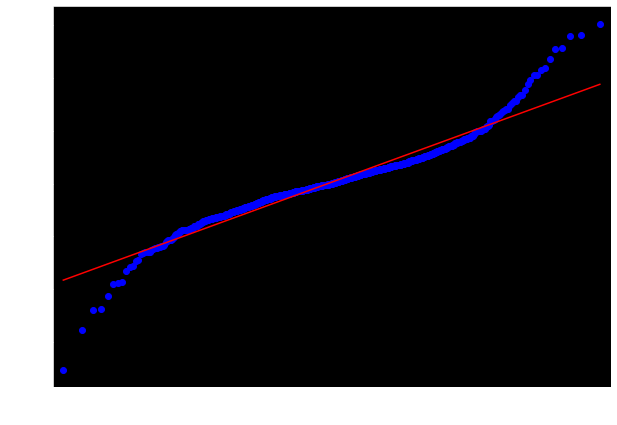

In [35]:
fig = pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(1,1,1)

qqplot(data=t(df=3).rvs(1000), line='s', ax=ax)
pyplot.show()

Далее рассмотрим нормальное распределение:

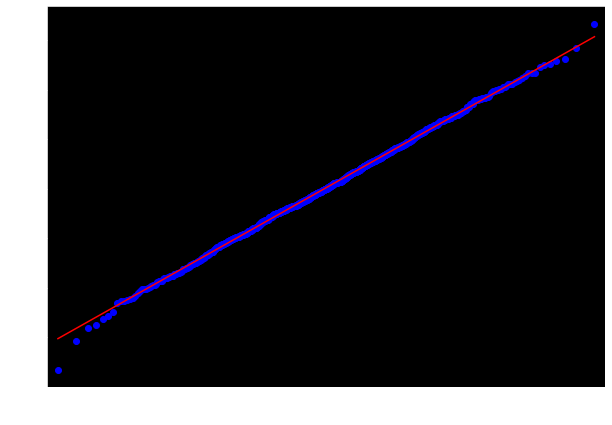

In [36]:
fig = pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(1,1,1)

qqplot(norm(100, 2).rvs(1000), line='s', ax=ax)
pyplot.show()

Теперь рассмотрим экспоненциальное распределение:

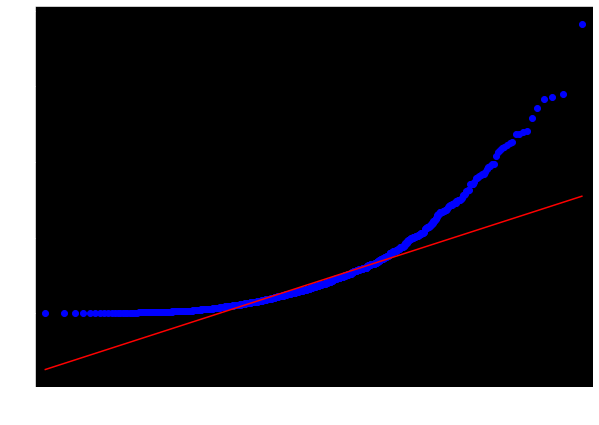

In [37]:
fig = pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(1,1,1)

qqplot(data=expon.rvs(loc=0, scale=1 / 1, size=1000), line='q', ax=ax)
pyplot.show()

Видим, что совсем не похоже на нормальное распределение.

Итак, Q–Q plot — это инструмент визуализации, который помогает нам в проверке сложной гипотезы принадлежности нормальному распределению. 

Плюсы метода:

- Графически позволяет проиллюстрировать принадлежность выборки нормальному распределению; 

Минусы метода:

- Нет никакого критерия. Непонятно, в какой момент график еще похож на прямую, а в какой нет?


----


## Критерий согласия на практике: нужен ли он для t-test?


В данной части лекции мы постараемся ответить на вопрос: могут ли помочь критерии согласия для t-test?

Как мы уже знаем  из прошлых лекций, нормальность данных никогда не нужна была для t-test. Но не все об этом знают! Поэтому многие аналитики любят использовать такую процедуру:

- Сначала мы проверяем данные на нормальность. 
- Если тест не отвергся мы считаем, что данные нормальны и t-test можно применять.
    - А если отвергся, то t-test неприменим.
    
Давайте это проверим! Как именно? С помощью Монте-Карло! **Но только мы проверим "наоборот"**: мы будем запускать t-test только тогда, когда Шапиро отверг нормальность данных!

В качестве распределения выборки возьмем экспоненциальное распределение.

In [47]:
numpy.random.seed(35)
N_exps = 1000
sample_size = 1000
bad_cnt=0
alpha=0.05

mean=10
dist = expon(scale = mean)
sz = 0

for i in range(N_exps):
    # Генерирую выборку
    sample = dist.rvs(sample_size)

    # Проверяем выборку на нормальность
    if shapiro(sample).pvalue > 0.05 :
        continue
        
    # Мы попали сюда только тогда, когда отвергся критерий о нормальности данных
    # Запускаю критерий и считаю p-value
    pvalue = ttest_1samp(sample, popmean=mean).pvalue

    # Проверяю, что pvalue < alpha
    bad_cnt += (pvalue < alpha)
    sz += 1

print(f"Процент отвержений данных на нормальность:  {round(sz/N_exps * 100, 0)}%")
print(f"FPR: {round(bad_cnt / sz, 4)}")
print(f"CI={proportion_confint(count = bad_cnt, nobs = sz, alpha=0.05, method='wilson')}")


Процент отвержений данных на нормальность:  100.0%
FPR: 0.054
CI=(0.04162131372306272, 0.06979215484605245)


Что мы видим? Критерий все также ошибается в 5% случаев! Критерий Шапиро отверг нормальность, а t-test все равно работает! А значит мы показали, что критерий согласия бесполезен!

----


Но что, если выборка маленькая? В прошлый раз мы говорили, что нужно провести Монте-Карло.
Но если вы не можете этого сделать? Например, у вас нет исторических данных, и выборка только начала собираться. Может ли помочь процедура описанная выше?


**То есть в отличие от примера выше, мы будем проверять критерий на маленьких выборках!** Проверим ее на Монте-Карло. Для честности будем смотреть только те исходы, когда критерии согласия не отверглись.

In [58]:
numpy.random.seed(35)
N_exps = 10000
sample_size = 5
bad_cnt=0
alpha=0.05

mean=10
dist = expon(scale = mean)
sz = 0

for i in range(N_exps):
    # Генерирую выборку
    sample    = dist.rvs(sample_size)

    # Проверяем выборку на нормальность
    if shapiro(sample).pvalue < 0.05 :
        # не идем дальше, если криетрий отвергся
        continue
        
    # Запускаю критерий и считаю p-value
    pvalue = ttest_1samp(sample, popmean=mean).pvalue

    # Проверяю, что pvalue < alpha
    bad_cnt += (pvalue < alpha)
    sz += 1

print(f"Критерий согласия не отвергся для теста и контроля в {round(sz/N_exps * 100, 0)}% случаев")
print(f"FPR: {round(bad_cnt / sz, 4)}")
print(f"CI={proportion_confint(count = bad_cnt, nobs = sz, alpha=0.05, method='wilson')}")


Критерий согласия не отвергся для теста и контроля в 84.0% случаев
FPR: 0.124
CI=(0.11709147118543192, 0.1311964857651455)


Как мы видим, критерий согласия тут не помог.

**Мораль:** критерии согласия никогда не нужны для t-test. В случае, если вы не можете запустить Монте-Карло, **то опираться на критерии согласия вы также не можете!**

# Итог

На этом занятии мы рассмотрели с вами разные критерии согласия: 
- Простые критерии:
    - В этом случае мы разобрали, как работает критерий Колмогорова.
        - Узнали, что он не работает в случае дискретных распределений.
- Сложные. Здесь мы разобрали разные критерии для проверки принадлежности нормальному распределению:
    - Критерий Колмогорова с поправкой Лиллиефорса
    - Критерий Шапиро-Уилка
    - Метод для визуализации принадлежности QQ-plot.
- А также показали, что критерии согласия могут быть **вредными для t-test**
	- в случае больших выборок при отвержении гипотезы о нормальности вы можете ошибочно отказаться от применения t-test, но t-test мы можем применять даже в случае не нормальных данных!
	- в случае маленьких выборок даже если гипотеза о нормальности НЕ отвергается, t-test применять все равно нельзя!